In [8]:
#Importing libraries
import pywt
import json
import time
import backtrader as bt
import datetime
import requests

import pandas as pd
import pandas_ta as ta
import numpy as np
import statsmodels.api as sm
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzer

from dotenv import load_dotenv

from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen as coint

In [9]:
#Reading Data and adding columns, spreads, etc
def requestData(reqAsset, reqInterval):
    reqFrom = round(time.time() - 60*reqInterval*720)
    req = requests.get('https://api.kraken.com/0/public/OHLC?pair={}&since={}&interval={}'.format(reqAsset, reqFrom, reqInterval))
    dic = list(json.loads(req.text)['result'])
    dic2 = json.loads(req.text)['result'][dic[0]]
    reqData = pd.DataFrame.from_dict(dic2)
    reqData.drop([5, 7], axis = 1, inplace=True)
    reqData.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    reqData.date = pd.to_datetime(reqData.date,  unit='s')
    reqData.set_index('date', inplace=True)
    reqData[['open', 'high', 'low', 'close', 'volume']] = reqData[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric, errors = 'coerce', axis = 1)
    return reqData

def addPercentReturn(dataframe):
    dataframe['percentReturn'] = (dataframe.close / dataframe.close.shift(1))
    dataframe.dropna(inplace=True)

def addLogReturn(dataframe):
    dataframe['logReturn'] = np.log(dataframe.close / dataframe.close.shift(1))
    dataframe.dropna(inplace=True)


In [21]:
#Cointegration Class

'''
Only caring about the 99% confidence level and r=0 in this case.
Use log returns for class method.
'''

class johansenTest:
    def __init__(self, df1, df2, lag=0):
        self.df1 = df1
        self.df2 = df2
        self.assets = pd.DataFrame({
            'asset1' : df1,
            'asset2' : df2
        })
        self.assets.dropna(axis=0, inplace = True)
        self.result = coint(self.assets, -1, lag)

    def run(self):
        if (self.result.lr1[0] > self.result.cvt[0][2]):
            self.finalResult = pd.DataFrame({
            'result' : (self.result.evec[0][0]*self.df1) + (self.result.evec[0][1]*self.df2)
            }, index = self.df1.index)
            self.finalResult.index = range(len(self.assets.asset1))
        return self.finalResult

assetList = ['XBTUSD', 'ETHUSD']
timeFrame = 15
assetRequest = []
for z in range(len(assetList)):
    assetRequest.append(requestData(assetList[z], timeFrame))
    addPercentReturn(assetRequest[z])
    addLogReturn(assetRequest[z])

jotestvar = johansenTest(assetRequest[0].logReturn, assetRequest[1].logReturn, 0).run()

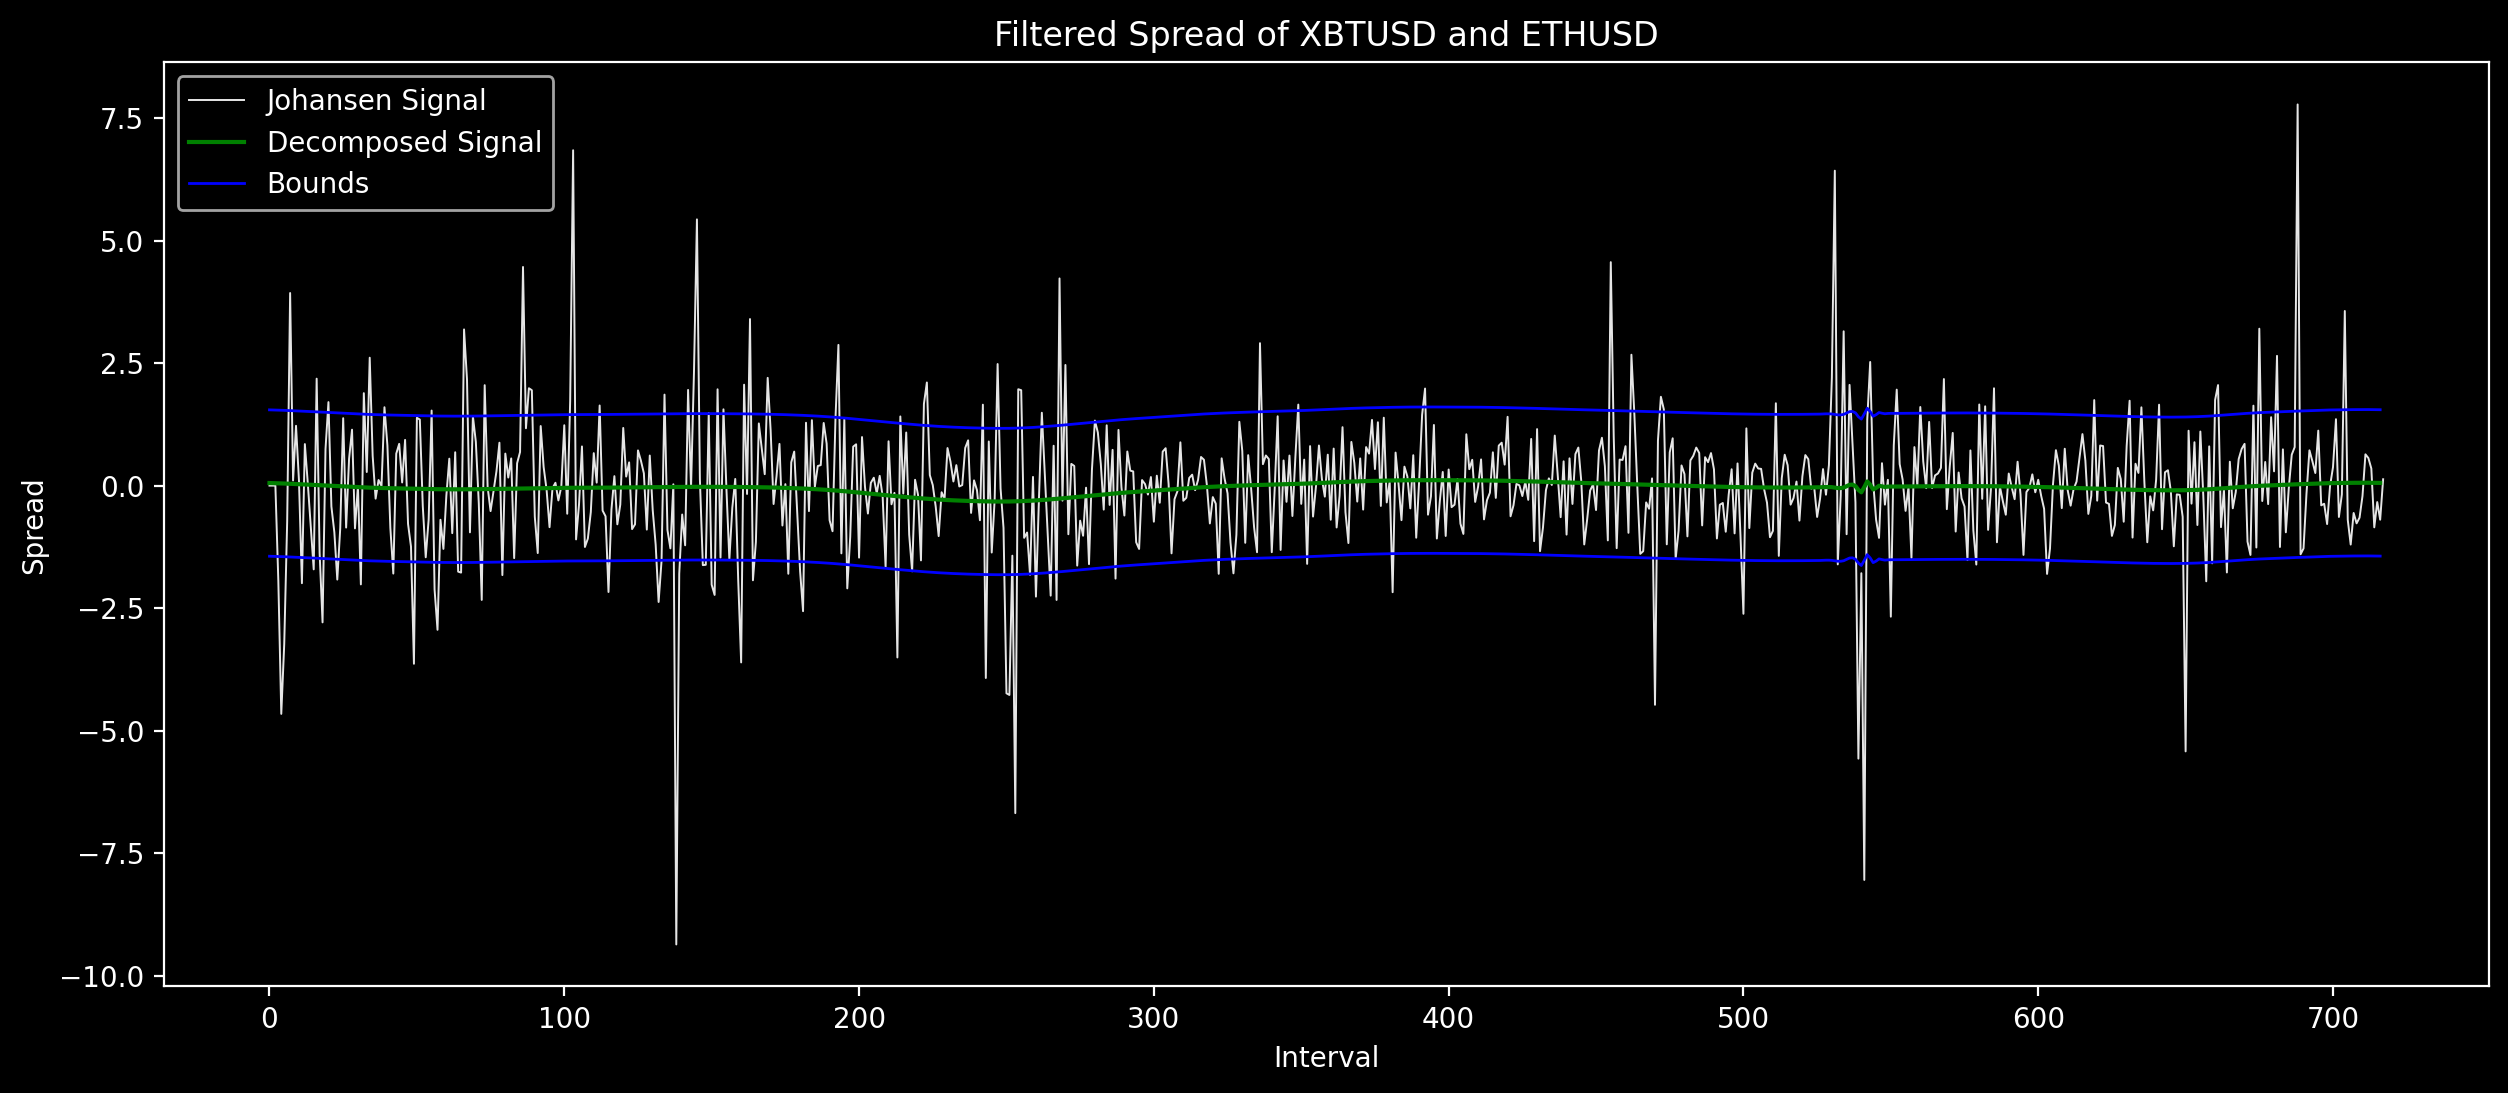

In [32]:
#Wavelet Class

'''
Wavelet deconstruction for noise reduction and signal lines.
Potentially unecessary however, its fun.
'''

class wavelet:
    def __init__(self, data, scale, wave='db6', mode='periodization'):
        if type(scale) == list:
            scale = scale[0]
        self.data = data.result
        self.coefficients = pywt.wavedec(data.result, wave, mode)
        self.coefficients[1:] = [pywt.threshold(x, (scale)*data.result.max(), 'soft') for x in self.coefficients[1:]]
        self.reconstructSignal = pywt.waverec(self.coefficients, wave, mode)

    def run(self, multiple):
        if type(multiple) == list:
            multiple = multiple[0]
        self.dnSignal = pd.DataFrame({
            'dnSignal' : self.reconstructSignal[1:]},
            index = [i for i in range(len(self.reconstructSignal[1:]))]
        )
        self.dnSignal['upper'] = self.dnSignal.dnSignal + ((multiple)*self.dnSignal.dnSignal.std())
        self.dnSignal['lower'] = self.dnSignal.dnSignal - ((multiple)*self.dnSignal.dnSignal.std())
        return self.dnSignal

wavedec = wavelet(jotestvar, 0.8, 'db6', 'periodization').run(15)
plt.figure(figsize = (15,6), dpi = 200)
plt.plot(jotestvar.result, c='w', alpha=0.9, linewidth = 0.7, label = 'Johansen Signal')
plt.plot(wavedec.dnSignal, alpha=1, c='g', linewidth = 1.5, label = 'Decomposed Signal')
plt.plot(wavedec.upper, alpha=1, c='b', linewidth = 1, label = 'Bounds')
plt.plot(wavedec.lower, alpha=1, c='b', linewidth = 1)
plt.title('Filtered Spread of {} and {}'.format(assetList[0], assetList[1]))
plt.xlabel('Interval')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [5]:
#Backtesting Strategy Implementation

'''
This method will QUICKLY eat memory if deployed on live data.
Code contains redundance for the purpose of readability.
The strategy has been modified from it's original implementation
'''

class jtStrat(bt.Strategy):

    params = (
        ('waveletScale', 0.8),
        ('stddev', 7),
        ('stopMult', 1)
    )
    
    def __init__(self):
        if type(self.params.stopMult) == list:
            self.params.stopMult = self.params.stopMult[0]
        
        self.asset1 = self.data0.close
        self.asset2 = self.data1.close
        self.dataList1, self.dataList2 = [] , []
        self.order1, self.order2 = None, None
        self.ZdownOup = None

    def next(self):
        self.logReturn1 = np.log(self.asset1[0] / self.asset1[-1])
        self.logReturn2 = np.log(self.asset2[0] / self.asset2[-1])
        self.dataList1.append(self.logReturn1)
        self.dataList2.append(self.logReturn2)

        if (len(self.dataList1) and len(self.dataList2) > 90):
            self.mainFrame = pd.DataFrame({
                'asset1' : self.dataList1,
                'asset2' : self.dataList2
            })
            self.jTest = johansenTest(self.mainFrame.asset1, self.mainFrame.asset2).run()
            self.wavelet = wavelet(self.jTest, self.params.waveletScale).run(self.params.stddev)

            currentPosition = self.jTest.result.iloc[-1]
            priorPosition = self.jTest.result.iloc[-2]
            upperSignal = self.wavelet.upper.iloc[-1]
            middleSignal = self.wavelet.dnSignal.iloc[-1]
            lowerSignal = self.wavelet.lower.iloc[-1]

            if self.position.size == 0:
                #Opening a new position
                if (currentPosition <= upperSignal and priorPosition >= upperSignal):
                    self.order = self.sell(
                        data = self.data0,
                        size = 0.4*cerebro.broker.getvalue() / self.data0.close,
                    )
                    self.order = self.buy(
                        data = self.data1,
                        size = 0.4*cerebro.broker.getvalue() / self.data1.close,
                    )
                    self.ZdownOup = 1
                elif (currentPosition >= lowerSignal and priorPosition <= lowerSignal):
                    self.order = self.buy(
                        data = self.data0,
                        size =  0.4*cerebro.broker.getvalue() / self.data0.close,
                    )
                    self.order = self.sell(
                        data = self.data1,
                        size = 0.4*cerebro.broker.getvalue() / self.data1.close,
                    )
                    self.ZdownOup = 0
            elif self.position:
                #Closing existing position via stop loss or trailing order
                if (self.ZdownOup == 0 and currentPosition <= middleSignal):
                    self.order = self.close(data = self.data0, exectype = bt.Order.StopTrail, trailpercent = 0.001)
                    self.order = self.close(data = self.data1, exectype = bt.Order.StopTrail, trailpercent = 0.001)
                    self.ZdownOup = None
                elif (self.ZdownOup == 0 and currentPosition <= (lowerSignal - self.params.stopMult*(middleSignal-lowerSignal))):
                    self.order = self.close(data = self.data0)
                    self.order = self.close(data = self.data1)
                    self.ZdownOup = None
                elif (self.ZdownOup == 1 and currentPosition >= middleSignal):
                    self.order = self.close(data = self.data0, exectype = bt.Order.StopTrail, trailpercent = 0.001)
                    self.order = self.close(data = self.data1, exectype = bt.Order.StopTrail, trailpercent = 0.001)
                    self.ZdownOup = None
                elif (self.ZdownOup == 1 and currentPosition >= (upperSignal + self.params.stopMult*(upperSignal-middleSignal))):
                    self.order = self.close(data = self.data0)
                    self.order = self.close(data = self.data1)
                    self.ZdownOup = None



In [6]:
#Backtesting Execution
cerebro = bt.Cerebro()

#Add Data
assetList = ['XBTUSD', 'ETHUSD']
timeFrame = 15
for i in assetList:
    assetRequest = requestData(i, timeFrame)
    addPercentReturn(assetRequest)
    addLogReturn(assetRequest)
    assetFrame = btfeeds.PandasData(dataname = assetRequest)
    cerebro.adddata(assetFrame)

#Broker 
cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission = 0.0006)

#Analyzer
cerebro.addanalyzer(btanalyzer.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(btanalyzer.Returns, _name = 'returns')

#Strategy and optimization
cerebro.addstrategy(jtStrat, waveletScale = [0.8], stddev = [7], stopMult = [2])
test = cerebro.run()

#Results
sharpe = test[0].analyzers.sharpe.get_analysis()['sharperatio']
returns = test[0].analyzers.returns.get_analysis()['rtot']
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Sharpe Ratio: ', sharpe)
print('Return: {}%'.format(round(returns*100, 3)))

#Graphing
# plt.rcParams['figure.figsize'] = [30, 10]
# plt.rcParams['figure.dpi'] = 50
# x = cerebro.plot()
# x[0][0]

Final Portfolio Value: 97126.92
Sharpe Ratio:  None
Return: -2.915%


In [52]:
optimizationFrame = pd.read_csv('./data/optimizationResultsJohansen.csv')